In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch_geometric.data import Data
from GCN_Regression import GCN_RegressionModel
from Trainer import Trainer
from utils import distance_threshold_graph,draw_graph, nearest_neighbors_graph
from utils import get_distance
data = xr.open_dataset("../AQ - Experiments/data/delhi_cpcb_2022.nc")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
df = data.to_dataframe()
# df = df["2022-01-01": "2022-12-31"]
df = data.to_dataframe().reset_index()
df = df[df["time"]=="2022-03-01 01:30:00"]
df = df.dropna(subset=["PM2.5"])

In [3]:
lat_list = [28.815329,28.647622,28.695381,28.4706914,28.7762,28.7256504,28.5512005,28.656756,28.7500499,28.498571,28.5710274,28.655935,28.5627763,28.6811736,28.628624,28.73282,28.58028,28.588333,28.5918245,28.611281,28.636429,28.684678,28.60909,28.570173,28.822836,28.56789,28.6573814,28.530785,28.623763,28.674045,28.639645,28.639645,28.563262,28.732528,28.6514781,28.5504249,28.710508,28.531346,28.672342,28.699793]

In [4]:
G = nearest_neighbors_graph(df, 8)

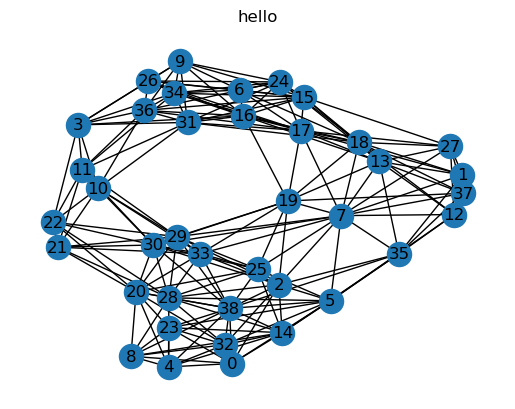

In [5]:
draw_graph(G,"hello")

In [7]:
distance_threshold_1 = 11

# Create an empty nx graph
G1 = nx.Graph()

# Iterate through each node in the dataset
for i in range(len(df)):
    lat1, lon1 = df.iloc[i]['latitude'], df.iloc[i]['longitude']
    pm = df.iloc[i]['PM2.5']
    G1.add_node(i, latitude=lat1, longitude=lon1, pm=pm)
    for j in range(i + 1, len(df)):
        lat2, lon2 = df.iloc[j]['latitude'], df.iloc[j]['longitude']
        distance = get_distance(lat1, lon1, lat2, lon2)
        if distance <= distance_threshold_1:
            G1.add_edge(i, j)

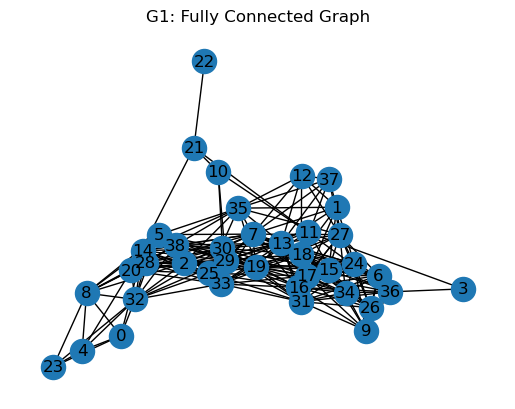

In [19]:
layout1 = nx.spring_layout(G1, k=0.5)

# Draw the graph with the specified layout
plt.figure()  
plt.title("G1: Fully Connected Graph")
nx.draw(G1, pos=layout1, with_labels=True)
plt.show()

In [16]:
node_features = [(G1.nodes[node]['latitude'], G1.nodes[node]['longitude']) for node in G1.nodes]
edge_index = torch.tensor(list(G1.edges)).t().contiguous()
y = torch.tensor([G1.nodes[node]['pm'] for node in G1.nodes], dtype=torch.float).view(-1, 1)
sorted_nodes = sorted(G1.nodes(), key=lambda node: G1.nodes[node]['latitude'])

# Divide train and test masks based on the sorted latitudes
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

for i, node in enumerate(G1.nodes):
    lat = G1.nodes[node]['latitude']
    if lat in lat_list[:25]:
        train_mask[i] = True
    else:
        test_mask[i] = True


data1 = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN_RegressionModel(2)


In [18]:
trainer = Trainer(model = model, data = data1, device = device, epochs=2500)
trainer.train(lr=0.01)

Epoch 0: Train RMSE 93.5684, Test RMSE 76.6727
Epoch 100: Train RMSE 47.0386, Test RMSE 36.9913
Epoch 200: Train RMSE 46.6545, Test RMSE 36.7181
Epoch 300: Train RMSE 45.1016, Test RMSE 35.3633
Epoch 400: Train RMSE 38.6501, Test RMSE 29.2134
Epoch 500: Train RMSE 37.8825, Test RMSE 27.9495
Epoch 600: Train RMSE 37.9413, Test RMSE 30.2905
Epoch 700: Train RMSE 37.6294, Test RMSE 28.0540
Epoch 800: Train RMSE 37.5108, Test RMSE 28.8284
Epoch 900: Train RMSE 37.4264, Test RMSE 29.0978
Epoch 1000: Train RMSE 37.2410, Test RMSE 29.5626
Epoch 1100: Train RMSE 37.0851, Test RMSE 29.5462
Epoch 1200: Train RMSE 37.0010, Test RMSE 30.1365
Epoch 1300: Train RMSE 36.7849, Test RMSE 29.0286
Epoch 1400: Train RMSE 36.7978, Test RMSE 28.2044
Epoch 1500: Train RMSE 36.6248, Test RMSE 29.4410
Epoch 1600: Train RMSE 36.5539, Test RMSE 28.9830
Epoch 1700: Train RMSE 36.4825, Test RMSE 29.3845
Epoch 1800: Train RMSE 36.4122, Test RMSE 29.6643
Epoch 1900: Train RMSE 36.4665, Test RMSE 31.0892
Epoch 2000: 

In [19]:
out = model(data1.x.to(device), data1.edge_index.to(device))  # Predicted PM values
test_rmse = torch.sqrt(torch.mean((out[data1.test_mask].squeeze() - data1.y[data1.test_mask].squeeze())**2))


In [20]:
test_rmse

tensor(30.4771, grad_fn=<SqrtBackward0>)